In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, auc, make_scorer, \
    confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder

RANDOM_STATE = 42

### Задание 1

На лекции вы познакомились с одним из методов оптимизации - методом градиентного спуска. В машинном обучении градиентный спуск используется для минимизации функции потерь при обучении моделей. Для лучшего понимания происходящего реализуем алгоритм руками.

Пусть на отрезке $[-2; 2]$ задана функция $y=x^4 + sin(x)$. Для поиска минимума этой функции реализуйте простейший алгоритм градиентного спуска. Начальное приближение возьмите равным 1. Выбрав темп обучения равным 0.1, найдите экстремум функции. Далее рассчитайте оптимальный темп обучения (такой, при котором алгоритм после первого же шага должен найти минимум функции).

Выберите все верные ответы из списка.

In [25]:
def f(x):
    # ваш код здесь
    y = x ** 4 + np.sin(x)

    return y


def gradient_f(x):
    # ваш код здесь
    grad = 4*x**3 + np.cos(x)
    
    return grad

In [40]:
learning_rate = 0.3  # темп обучения
iter = 1000  # базовое количество итераций

x0 = 1  # начальное приближение

In [111]:
# ваш код здесь
learning_rate = 0.1  # темп обучения
iter = 1000  # базовое количество итераций
x0 = 1  # начальное приближение
for i in range(iter):
    grad = gradient_f(x0)
    x0 = x0 - learning_rate * grad
    if i < 10:
        print(f'Итерация {i+1}: x = {x0:.3f}, y = {f(x0):.3f}')
x_, y_ = x0, f(x0)
print(f'Оптимум x: {x0:.3f}, y: {f(x0):.3f} ')
# Оптимум x: -0.5919847892393224, y: -0.4351967756964402 

Итерация 1: x = 0.546, y = 0.608
Итерация 2: x = 0.395, y = 0.410
Итерация 3: x = 0.278, y = 0.281
Итерация 4: x = 0.174, y = 0.174
Итерация 5: x = 0.073, y = 0.073
Итерация 6: x = -0.027, y = -0.027
Итерация 7: x = -0.127, y = -0.126
Итерация 8: x = -0.225, y = -0.221
Итерация 9: x = -0.318, y = -0.303
Итерация 10: x = -0.400, y = -0.364
Оптимум x: -0.592, y: -0.435 


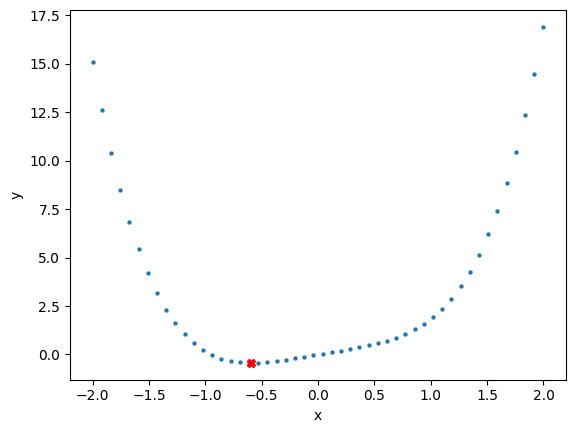

In [109]:
x = np.linspace(-2, 2, num=50)
y = f(x)

plt.scatter(x, y, marker='.', linewidths=.1)
plt.plot(x_, y_, marker = 'X', color = 'red')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### Задание 2

Рассмотрим набор данных о заболевании раком. Здесь представлены два различных типа рака и необходимо отделить один от другого. Для этого разделите набор данных на тренировочную и тестовую выборки, постройте логистическую регрессию (здесь и далее в форме не масштабируем признаки для простоты) и выполните предсказания. Рассчитав коэффициенты модели, определите признак, который оказывает наиболее сильное влияние на наличие рака типа `'B'` у пациента. В качестве ответа сдайте название признака без кавычек.

In [3]:
# Считайте набор данных из файла Cancer_Data.csv
data = pd.read_csv('Cancer_Data.csv').drop(['id', 'Unnamed: 32'], axis=1)
data.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
# Закодируйте значения в колонке с целевой переменной. Рак типа B - класс 1, рак типа M - класс 0
# ваш код здесь
data['diagnosis'].replace({'B': 1, 'M': 0}, inplace=True)
print(data.diagnosis.value_counts())

diagnosis
1    357
0    212
Name: count, dtype: int64


In [5]:
X = data.drop('diagnosis', axis=1)
y = data['diagnosis']

In [6]:
# Разделите набор на тренировочную и тестовую выборки. размер тестовой выборки - 0.4, стратификация по целевой переменной, перемешивание включено,
# random_state=RANDOM_STATE
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.4,
    random_state=RANDOM_STATE,
    shuffle=True,
    stratify=y) # ваш код здесь

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((341, 30), (228, 30), (341,), (228,))

In [7]:
# Создайте модель логистической регрессии и подберите ее оптимальные параметры с помощью GridSearchCV. Целевая метрика - ROC-AUC, количество фолдов 10
log_reg = LogisticRegression(random_state=RANDOM_STATE) # ваш код здесь

params = {
    'C' : [0.1, 0.3, 0.5, 0.7, 1.0]
}

clf = GridSearchCV(
    estimator=log_reg,
    param_grid=params,
    scoring='roc_auc',
    cv=10) # ваш код здесь

clf.fit(X_train, y_train)
best_params = clf.best_params_
print(f'Лучшие параметры: {best_params}')
print(f'Лучший скор: {clf.best_score_}')

Лучшие параметры: {'C': 0.1}
Лучший скор: 0.9893023643023643


In [8]:
# Обучите модель логистической регрессии с лучшими параметрами на тренировочной выборке и выполните предсказания на тестовой
model = LogisticRegression(random_state=RANDOM_STATE, C=0.1) #clf.best_estimator_ # ваш код здесь
model.fit(X_train, y_train)
pred = model.predict(X_test) # ваш код здесь
roc_auc = roc_auc_score(y_test, pred)
print(f'ROC-AUC на тестовом наборе: {roc_auc:.2f}')

ROC-AUC на тестовом наборе: 0.93


In [9]:
# Рассчитав коэффициенты модели, определите признак, который оказывает наиболее сильное влияние на наличие рака типа `'B'` у пациента
# ваш код здесь
coefs = model.coef_[0]
feature_names = X_train.columns
df_coefs = pd.DataFrame(
    {'Feature': feature_names,
     'Coefficient': coefs}
)
df_coefs['Coef_abs'] = df_coefs['Coefficient'].abs()
df_coefs = df_coefs.sort_values('Coefficient', ascending=False)

In [33]:
df_coefs.iloc[0]['Feature']

'radius_worst'

### Задание 3

Давайте интерпретируем результаты логистической регрессии.


In [75]:
# Будете ли вы использовать те же X и y как и в предыдущем задании?
X, y = data.drop('diagnosis', axis=1), data['diagnosis'] # ваш код здесь

In [35]:
log_reg_2 = LogisticRegression(random_state=RANDOM_STATE)

params = {
    'C' : [0.1, 0.3, 0.5, 0.7, 1.0]
}

clf = GridSearchCV(log_reg_2, params, scoring='roc_auc', cv=10)
clf.fit(X, y)
print(f'Best score is {clf.best_score_}, best params are {clf.best_params_}')

Best score is 0.991170892599464, best params are {'C': 1.0}


In [36]:
lr_2 = LogisticRegression(random_state=RANDOM_STATE, C=1.0)
lr_2.fit(X, y)
pred_2 = lr_2.predict(X) # ваш код здесь
roc_auc_2 = roc_auc_score(y, pred_2)
print(f'ROC-AUC на всем наборе: {roc_auc_2:.2f}')

ROC-AUC на всем наборе: 0.94


In [51]:
# пятый пациент
float(lr_2.predict_proba(X)[:,1][4])

3.7153946065515812e-06

In [48]:
# ваш код здесь
coefs_2 = lr_2.coef_[0]
feature_names_2 = X.columns
df_coefs_2 = pd.DataFrame(
    {'Feature': feature_names_2,
     'Coefficient': coefs_2}
)
df_coefs_2['Coef_abs'] = df_coefs_2['Coefficient'].abs()
df_coefs_2 = df_coefs_2.sort_values('Coefficient', ascending=False)
df_coefs_2[:10]

,Feature,Coefficient,Coef_abs
20,radius_worst,1.028790,1.028790
0,radius_mean,0.967719,0.967719
1,texture_mean,0.467707,0.467707
11,texture_se,0.382975,0.382975
2,perimeter_mean,0.277307,0.277307
12,perimeter_se,0.149590,0.149590
10,radius_se,0.042072,0.042072
14,smoothness_se,-0.003262,0.003262
19,fractal_dimension_se,-0.003389,0.003389
9,fractal_dimension_mean,-0.009974,0.009974


In [76]:
X.iloc[4, :]#[['proba']]#.describe()

radius_mean                  20.290000
texture_mean                 14.340000
perimeter_mean              135.100000
area_mean                  1297.000000
smoothness_mean               0.100300
compactness_mean              0.132800
concavity_mean                0.198000
concave points_mean           0.104300
symmetry_mean                 0.180900
fractal_dimension_mean        0.058830
radius_se                     0.757200
texture_se                    0.781300
perimeter_se                  5.438000
area_se                      94.440000
smoothness_se                 0.011490
compactness_se                0.024610
concavity_se                  0.056880
concave points_se             0.018850
symmetry_se                   0.017560
fractal_dimension_se          0.005115
radius_worst                 22.540000
texture_worst                16.670000
perimeter_worst             152.200000
area_worst                 1575.000000
smoothness_worst              0.137400
compactness_worst        

In [78]:
# 22.54 - > 23.54
patient_5 = X.iloc[4, :]
# patient_5['radius_worst'] = patient_5['radius_worst'] + 1
patient_5 = patient_5.values.reshape(1, -1)
new_result = lr_2.predict_proba(patient_5)[:,1]
new_radius = 23.54
print(f'Вероятность рака 5-го пациента: {new_result}')


Вероятность рака 5-го пациента: [1.03944079e-05]


In [64]:
patient_5

radius_mean                  20.290000
texture_mean                 14.340000
perimeter_mean              135.100000
area_mean                  1297.000000
smoothness_mean               0.100300
compactness_mean              0.132800
concavity_mean                0.198000
concave points_mean           0.104300
symmetry_mean                 0.180900
fractal_dimension_mean        0.058830
radius_se                     0.757200
texture_se                    0.781300
perimeter_se                  5.438000
area_se                      94.440000
smoothness_se                 0.011490
compactness_se                0.024610
concavity_se                  0.056880
concave points_se             0.018850
symmetry_se                   0.017560
fractal_dimension_se          0.005115
radius_worst                 23.540000
texture_worst                16.670000
perimeter_worst             152.200000
area_worst                 1575.000000
smoothness_worst              0.137400
compactness_worst        

In [55]:
X.iloc[4, :]['radius_worst'] + 1

23.54

In [86]:
p65 = X['radius_worst'].quantile(0.65)
p99 = X['radius_worst'].quantile(0.99)
print(p99, p65)

30.762800000000002 16.46


In [85]:
len(X[X['radius_worst'] > new_radius]) / len(X)


0.10369068541300527

In [100]:
print(f'Вероятность рака 5-го пациента: {lr_2.predict_proba(patient_5)[:,1]}')
cancer_all = pd.Series(lr_2.predict_proba(X.drop('proba', axis=1))[:,1])
p38_all = cancer_all.quantile(0.40)
p65_all = cancer_all.quantile(0.65)
p93_all = cancer_all.quantile(0.93)
print('38 квантиль:', p38_all)
print('65 квантиль:', p65_all)
print('93 квантиль:', p93_all)


Вероятность рака 5-го пациента: [1.03944079e-05]
38 квантиль: 0.777561752997377
65 квантиль: 0.9886331448862105
93 квантиль: 0.9992931534336035


In [102]:
cancer_all = lr_2.predict_proba(X.drop('proba', axis=1))[:,1] # > new_result #.count() #.sum()
(cancer_all > new_result)

array([False, False, False,  True,  True,  True, False,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True, False, False, False,  True,
       False, False,  True, False,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
       False,  True,  True,  True,  True, False, False,  True,  True,
        True, False,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False,  True,  True,  True,
        True, False,

In [103]:
X['proba'] = cancer_all
X[X['proba'] > new_result[0]]
478 / 569

0.8400702987697716

### Задание 4

Постройте матрицу ошибок и рассчитайте необходимые метрики. Выберите все верные ответы в списке.

In [10]:
# учим на всем наборе данных
model_matrix = LogisticRegression(random_state=RANDOM_STATE, C=0.1) #clf.best_estimator_ # ваш код здесь
model_matrix.fit(X, y)
pred_all = model_matrix.predict(X) # ваш код здесь
roc_auc_all = roc_auc_score(y, pred_all)
print(f'ROC-AUC на тестовом наборе: {roc_auc_all:.2f}')

ROC-AUC на тестовом наборе: 0.94


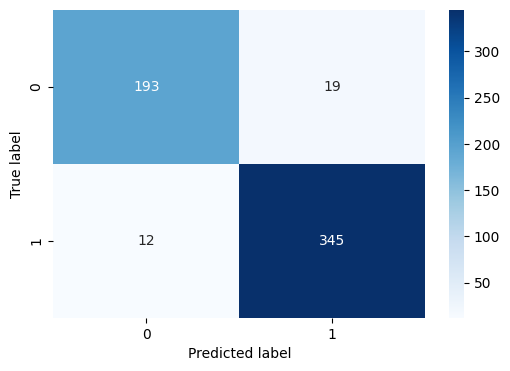

In [11]:
# cf_matrix = confusion_matrix(y_test.values, pred) # ваш код здесь
cf_matrix = confusion_matrix(y, pred_all) # ваш код здесь
plt.figure(figsize=(6, 4))

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='.4g')

# ax.set_title('Confusion Matrix\n')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')

plt.show()

In [12]:
# X_test,
y_test.value_counts()
y.value_counts()

diagnosis
1    357
0    212
Name: count, dtype: int64

In [13]:
print('M-cancer', 191/212)
print('B-cancer false', 13/357)
print('B-cancer true', 344/357)

M-cancer 0.9009433962264151
B-cancer false 0.036414565826330535
B-cancer true 0.9635854341736695


### Задание 5

Выполните предсказания на тестовой выборке и рассчитайте значение метрики AUC-ROC, а также для наглядности постройте ROC-кривую.

При разных порогах по вероятности (0.25, 0.5, 0.75) рассчитайте значения метрик (точность, полнота, F1-мера, ROC-AUC) и выберите все верные ответы.

In [14]:
# ваш код здесь
roc_auc = roc_auc_score(y_test, pred)
print(f'ROC-AUC на тестовом наборе: {roc_auc:.2f}')

ROC-AUC на тестовом наборе: 0.93


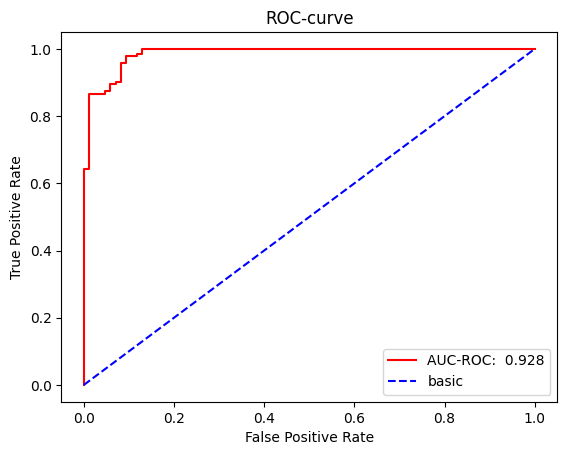

In [15]:
pred_proba = model.predict_proba(X_test)[::, 1]
fpr, tpr, thresholds = roc_curve(y_test, pred_proba)

plt.plot(fpr, tpr, c='r', label=f'AUC-ROC: {roc_auc_score(y_test, pred): .3f}')
plt.plot(fpr, fpr, linestyle='dashed', c='b', label='basic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
plt.legend()
plt.show()

In [16]:
len(pred_proba)
thresholds
auc(fpr, tpr)
model.predict_proba(X_test)[::, 1]

array([8.97784098e-01, 4.90886990e-01, 9.94680510e-01, 9.93540934e-01,
       9.84352010e-01, 4.37486777e-02, 9.98136265e-01, 6.38006587e-09,
       4.92353155e-01, 3.34130856e-03, 9.20435541e-01, 9.68486829e-01,
       1.07993898e-03, 6.79911028e-05, 9.54524215e-01, 2.59097256e-02,
       1.60456675e-03, 4.32336876e-09, 9.59014196e-01, 9.86483095e-01,
       3.67952318e-07, 1.91723454e-02, 6.60793115e-01, 9.98146940e-01,
       9.27536820e-01, 9.93876238e-01, 9.12031731e-01, 6.22343588e-06,
       9.92397953e-01, 9.49359433e-01, 9.94501139e-01, 9.81163216e-01,
       8.40041747e-01, 9.35163465e-01, 1.66499950e-06, 9.91705879e-01,
       9.98053512e-01, 6.92889832e-01, 9.62091657e-01, 7.85153793e-01,
       4.43609634e-01, 9.98354711e-01, 9.90836559e-01, 1.03947915e-34,
       9.79300767e-01, 9.48310469e-01, 4.57731701e-01, 9.98118188e-01,
       5.54516117e-03, 9.91664932e-01, 6.54840101e-01, 7.76196242e-03,
       9.78078993e-01, 9.95633886e-19, 9.88978847e-01, 1.04595471e-05,
      

In [17]:
thresholds = [0.25, 0.5, 0.75]
# ваш код здесь
for threshold in thresholds:
    y_pred = (pred_proba >= threshold)#.astype(int)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"\nПорог: {threshold}")
    print(f"Точность (Precision): {precision:.3f}")
    print(f"Полнота (Recall): {recall:.3f}")
    print(f"F1-мера: {f1:.3f}")


Порог: 0.25
Точность (Precision): 0.894
Полнота (Recall): 1.000
F1-мера: 0.944

Порог: 0.5
Точность (Precision): 0.928
Полнота (Recall): 0.986
F1-мера: 0.956

Порог: 0.75
Точность (Precision): 0.950
Полнота (Recall): 0.930
F1-мера: 0.940


### Задание 6

Найти порог, при котором F1-мера будет принимать максимальное значение.

In [18]:
# Порог надо искать среди чисел от 0 до 1 с шагом 0.001
best_thresh = 0
best_f1 = 0

# ваш код здесь
new_thresh = np.linspace(0, 1, 1000)
for threshold in new_thresh:
    y_best = 0
    y_pred = (pred_proba >= threshold)
    f1 = f1_score(y_test, y_pred)
    if f1 > best_f1:
        y_best = y_pred
        best_f1 = f1
        best_thresh = threshold

print(y_best)
print(f"Оптимальный порог: {best_thresh:.3f}")
print(f"Максимальное значение F1-меры: {best_f1:.3f}")

0
Оптимальный порог: 0.458
Максимальное значение F1-меры: 0.963


### Задание 7

Если для исследователя точность важнее полноты (принять ${\beta}$ = 0.5), то какой порог нужно выбрать для максимизации F-меры (перебор порога делать, как в предыдущем задании)? Рассчитайте также взвешанное значение F-меры в этом случае. Выберите все верные ответы из списка.

В этой [статье](https://habr.com/ru/companies/ods/articles/328372/) приведена формула взвешанной F-меры: $F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\beta^2 \cdot precision + recall}$

In [23]:
# Тут процедура аналогичная, только вместо F1-меры надо считать взвешенную F-меру
best_thresh = 0
best_f_harmonic = 0
beta = 0.5

def f_harmonic(beta, precision, recall):
    return (1 + beta**2) * ((precision * recall) / (beta**2 * precision + recall))

# ваш код здесь
new_thresh = np.linspace(0, 1, 1000)
for threshold in new_thresh:
    y_best = 0
    y_pred = (pred_proba >= threshold)

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f_harmonic_score = f_harmonic(beta, precision, recall)

    if f_harmonic_score > best_f_harmonic:
        # y_best = y_pred
        best_f_harmonic = f_harmonic_score
        best_thresh = threshold

y_best = (pred_proba >= best_thresh).astype(int)
precision = precision_score(y_test, y_best)
recall = recall_score(y_test, y_best)


print(f"Оптимальный порог: {best_thresh:.3f}")
print(f"Максимальное значение F1-меры: {best_f_harmonic:.3f}")
print(f'Точность: {precision:.3f}')
print(f'Полнота: {recall:.3f}')

[1 0 1 1 1 0 1 0 0 0 1 1 0 0 1 0 0 0 1 1 0 0 0 1 1 1 1 0 1 1 1 1 0 1 0 1 1
 0 1 0 0 1 1 0 1 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 1 1 1 1 0 1 1 1 1 1 1 1 0 1
 1 0 1 0 0 1 1 1 0 1 0 0 0 0 1 1 1 0 0 1 0 0 1 0 1 0 1 1 0 0 1 1 0 1 1 0 1
 0 1 0 1 1 1 1 0 1 1 0 0 0 1 0 1 1 0 0 1 1 0 1 1 1 0 0 1 1 1 0 0 0 0 1 1 1
 1 0 0 0 1 0 0 0 1 0 1 1 1 0 0 1 1 0 0 1 1 1 0 0 0 1 1 0 0 1 1 0 0 0 1 1 1
 1 0 1 1 0 1 1 1 1 1 0 1 1 0 0 1 1 0 0 1 0 0 0 1 1 0 1 1 0 0 1 0 1 0 1 0 1
 0 1 1 0 1 1]
Оптимальный порог: 0.879
Максимальное значение F1-меры: 0.964
Точность: 0.992
Полнота: 0.867


### Задание 8

Вернемся к предсказаниям нашей логистической регрессии. Воспользуемся метрикой gini для сравнения нашей модели со случайной. Подробнее про метрику можно почитать [здесь](https://habr.com/ru/companies/ods/articles/350440/). Постройте случайную модель (используя наш random seed из ноутбука) и посчитайте разность нашего gini и gini случайной модели. Выберите правильный ответ.

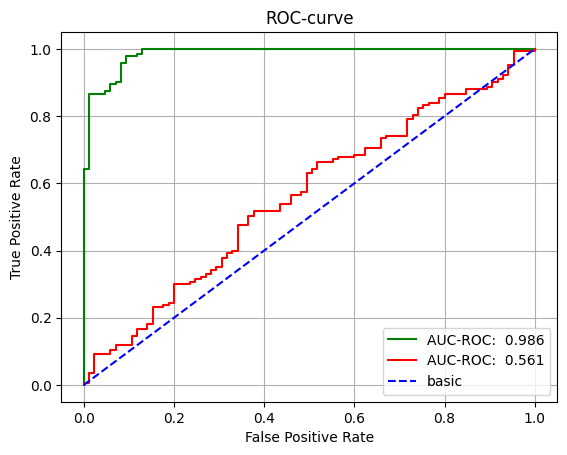

In [35]:
rng = np.random.RandomState(RANDOM_STATE)
random_probs = rng.uniform(0, 1, 228)

pred_proba = model.predict_proba(X_test)[::, 1]
fpr_1, tpr_1, thresholds_1 = roc_curve(y_test, pred_proba)

fpr, tpr, thresholds = roc_curve(y_test, random_probs)

plt.plot(fpr_1, tpr_1, c='g', label=f'AUC-ROC: {roc_auc_score(y_test, pred_proba): .3f}')
plt.plot(fpr, tpr, c='r', label=f'AUC-ROC: {roc_auc_score(y_test, random_probs): .3f}')
plt.plot(fpr, fpr, linestyle='dashed', c='b', label='basic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
plt.legend()
plt.grid()
plt.show()

In [30]:
strong_auc = roc_auc_score(y_test, pred_proba)
random_auc = roc_auc_score(y_test, random_probs)
strong_auc, random_auc
gini_our = 2 * strong_auc - 1 # ваш код здесь
gini_random = 2 * random_auc - 1 # ваш код здесь

In [33]:
print('Gini our:', gini_our)
print('Gini random:', gini_random)
gini_our - gini_random


Gini our: 0.9721925133689839
Gini random: 0.12299465240641716


0.8491978609625668